In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
data = pd.read_csv('exchange_rate.csv')

In [3]:
data

,date,Ex_rate
0,01-01-1990 00:00,0.785500
1,02-01-1990 00:00,0.781800
2,03-01-1990 00:00,0.786700
3,04-01-1990 00:00,0.786000
4,05-01-1990 00:00,0.784900
...,...,...
7583,06-10-2010 00:00,0.718494
7584,07-10-2010 00:00,0.721839
7585,08-10-2010 00:00,0.723197
7586,09-10-2010 00:00,0.720825


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7588 entries, 0 to 7587
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   date     7588 non-null   object 
 1   Ex_rate  7588 non-null   float64
dtypes: float64(1), object(1)
memory usage: 118.7+ KB


In [5]:
data.isnull().sum()

date       0
Ex_rate    0
dtype: int64

In [6]:
data['date'] = pd.to_datetime(data['date'], format='%d-%m-%Y %H:%M')

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7588 entries, 0 to 7587
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   date     7588 non-null   datetime64[ns]
 1   Ex_rate  7588 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 118.7 KB


### Plot

In [8]:
def plot_time_series(df):
    """
    Plot a time series graph with highlighted highest and lowest points.
    
    Parameters:
    df (DataFrame): The DataFrame containing the time series data.
    """
    sns.set(style="whitegrid")
    
    plt.figure(figsize=(16, 8))
    plt.plot(df.index, df['Ex_rate'], color='#0057b7', linewidth=2.5, label='Exchange Rate')
    
    highest_point = df['Ex_rate'].idxmax()
    lowest_point = df['Ex_rate'].idxmin()
    
    plt.scatter(highest_point, df['Ex_rate'].max(), color='green', s=100, zorder=5, label='Highest Point')
    plt.scatter(lowest_point, df['Ex_rate'].min(), color='red', s=100, zorder=5, label='Lowest Point')
    
    plt.text(highest_point, df['Ex_rate'].max(), f'  Highest: {df["Ex_rate"].max():.4f}', 
             horizontalalignment='left', fontsize=12, color='green', weight='bold', verticalalignment='bottom')
    plt.text(lowest_point, df['Ex_rate'].min(), f'  Lowest: {df["Ex_rate"].min():.4f}', 
             horizontalalignment='left', fontsize=12, color='red', weight='bold', verticalalignment='top')
    
    plt.title('Currency Exchange Rate Over Time', fontsize=20, fontweight='bold', color='#333333')
    plt.xlabel('Date', fontsize=14, color='#333333')
    plt.ylabel('Exchange Rate', fontsize=14, color='#333333')
    
    plt.xticks(rotation=45, ha='right', fontsize=12, color='#555555')
    plt.yticks(fontsize=12, color='#555555')
    
    # Ensure the x-axis ticks are formatted properly with dates
    plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%d-%m-%Y'))
    
    plt.grid(True, linestyle='--', alpha=0.6)
    
    plt.legend(loc='upper left', fontsize=12, frameon=False, labelspacing=1.2)
    
    plt.tight_layout()
    plt.show()


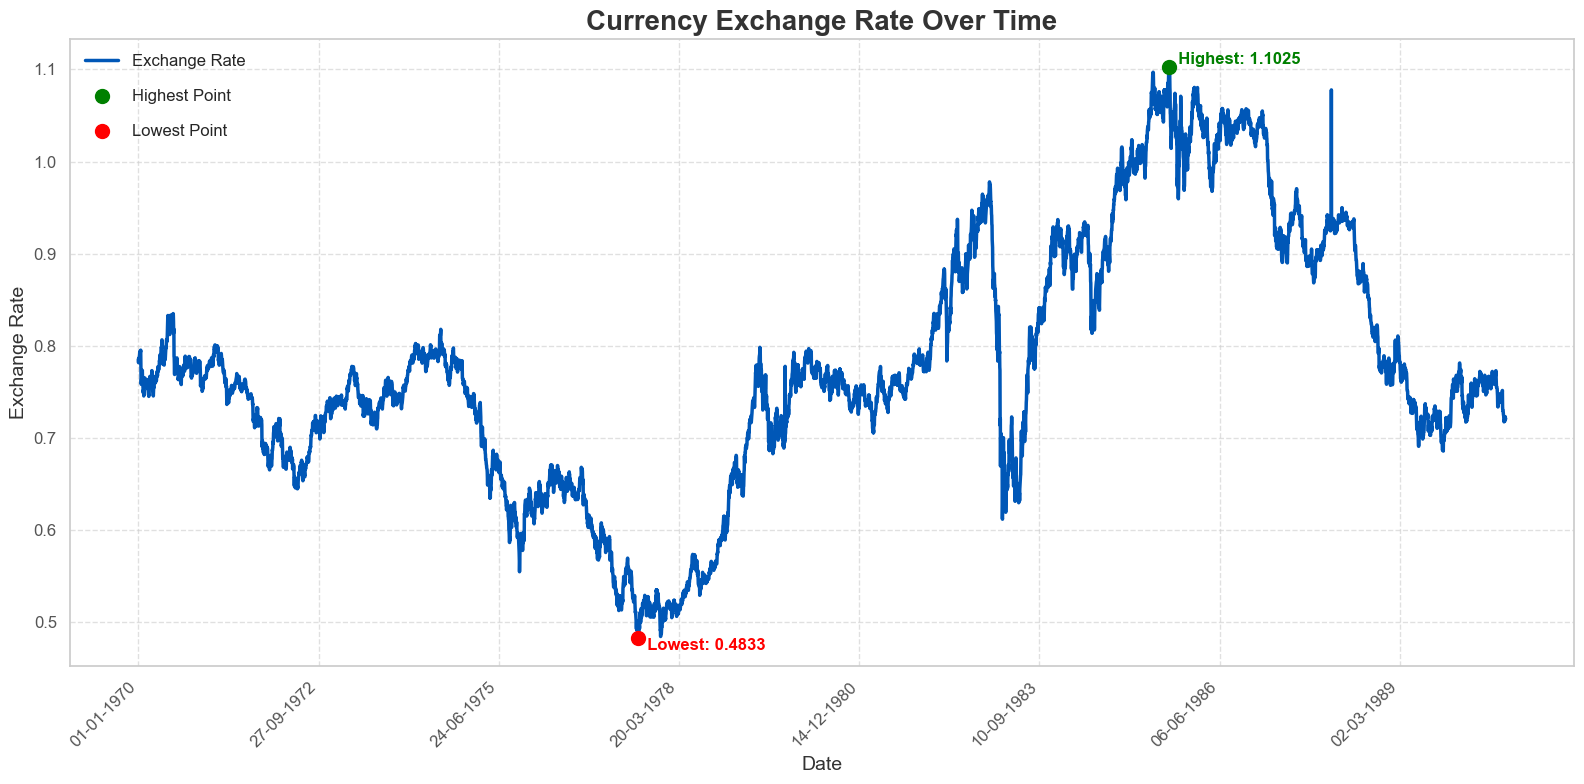

In [9]:
plot_time_series(df= data)

### Model training

In [10]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

In [11]:
def plot_acf_pacf(df):
    """
    Plot ACF and PACF to determine the parameters (p, d, q) for the ARIMA model.
    
    Parameters:
    df (DataFrame): The DataFrame containing the time series data.
    """
    # ADF Test for Stationarity
    result = adfuller(df['Ex_rate'])
    print(f"ADF Statistic: {result[0]}")
    print(f"p-value: {result[1]}")
    
    # Differencing if the series is not stationary (i.e., p-value > 0.05)
    if result[1] > 0.05:
        df['Ex_rate_diff'] = df['Ex_rate'].diff().dropna()
        print("Differencing applied to make the series stationary.")
        df = df.dropna()
    
    # ACF and PACF plots
    fig, ax = plt.subplots(1, 2, figsize=(16, 8))
    plot_acf(df['Ex_rate'], ax=ax[0], lags=40)
    plot_pacf(df['Ex_rate'], ax=ax[1], lags=40)
    
    plt.tight_layout()
    plt.show()

ADF Statistic: -1.6649941807381528
p-value: 0.4492327353597901
Differencing applied to make the series stationary.


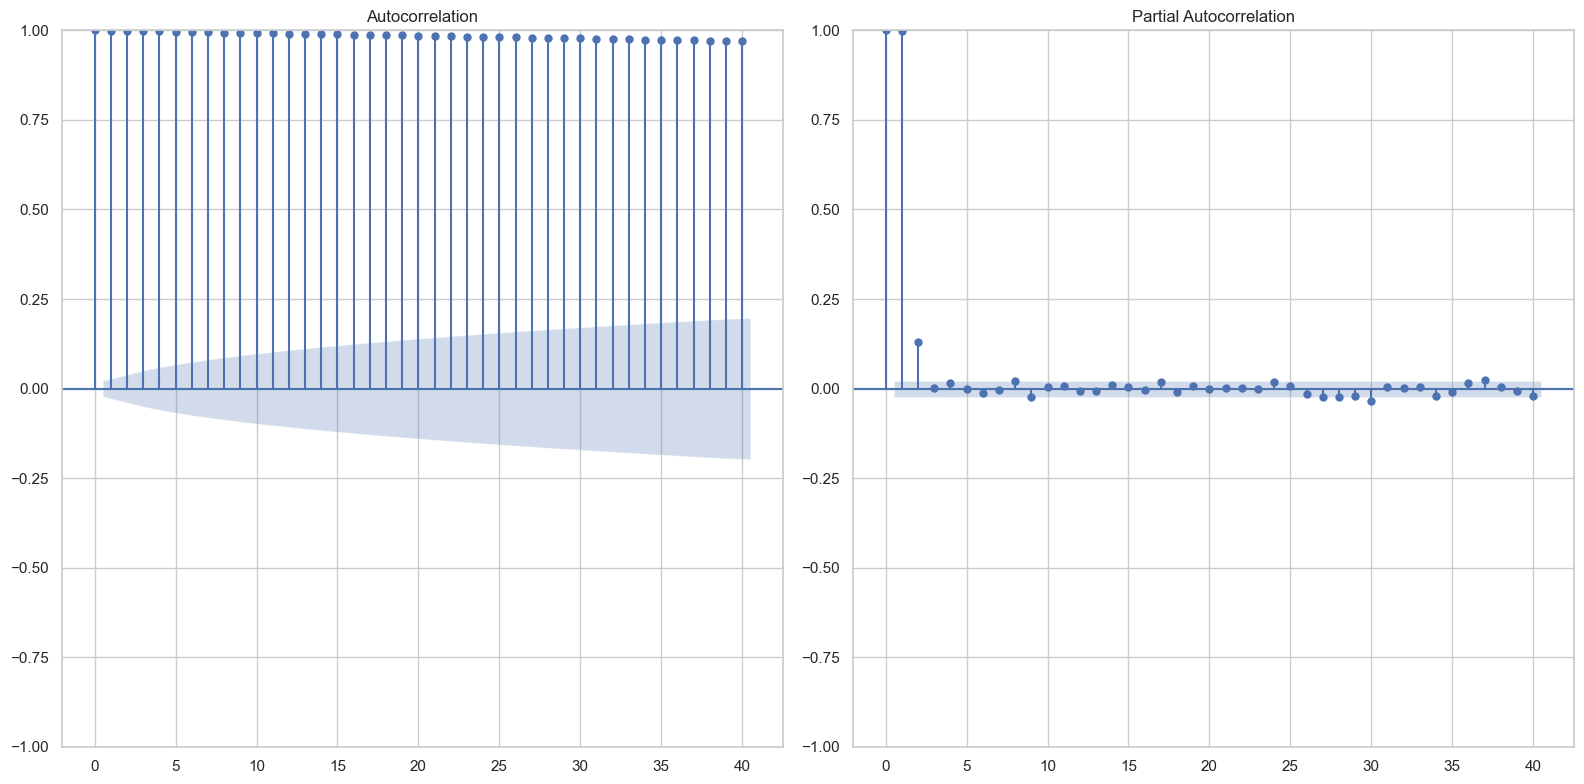

In [12]:
plot_acf_pacf(df= data)

In [13]:
from statsmodels.tsa.stattools import adfuller

# Perform ADF test on the differenced series
result_diff = adfuller(data['Ex_rate_diff'].dropna())  # Ensure no NaN values

print(f"ADF Statistic (Differenced): {result_diff[0]}")
print(f"p-value (Differenced): {result_diff[1]}")

ADF Statistic (Differenced): -99.39343120118629
p-value (Differenced): 0.0


In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller

def adf_test(series):
    """
    Performs the Augmented Dickey-Fuller (ADF) test to assess stationarity.
    
    The test checks for the presence of a unit root in the time series.
    A lower p-value (typically < 0.05) indicates stationarity.
    
    Returns a dictionary containing the ADF statistic and p-value.
    """
    result = adfuller(series)
    return {"ADF Statistic": result[0], "p-value": result[1]}

In [15]:
series = data["Ex_rate"]

In [16]:
adf_test(series.diff().dropna())

{'ADF Statistic': np.float64(-99.39343120118629), 'p-value': 0.0}

# **Estimating Initial ARIMA Parameters Using ACF and PACF for Currency Time Series**

## **1. Introduction**  
Autoregressive Integrated Moving Average (ARIMA) modeling is widely used for time series forecasting. Selecting the optimal initial parameters **(p, d, q)** is crucial for model performance. This report outlines how we leveraged **Autocorrelation Function (ACF)** and **Partial Autocorrelation Function (PACF)** plots to determine these parameters for a given currency exchange rate time series.

---

## **2. Stationarity Analysis (Determining \( d \))**  
Before choosing \( p \) and \( q \), we first test for stationarity using the **Augmented Dickey-Fuller (ADF) test**. The test checks for the presence of a unit root:

- **ADF Statistic**: -99.39  
- **p-value**: 0.0  

Since the **p-value is below 0.05**, we **reject the null hypothesis**, confirming that the time series is stationary after differencing.  
Thus, the order of differencing (**\( d \)**) is **1**.

---

## **3. Identifying \( p \) and \( q \) Using ACF and PACF**  
Once stationarity is achieved, we use ACF and PACF plots to determine the values for **\( p \) (AR order) and \( q \) (MA order)**.

### **3.1. Autocorrelation Function (ACF)**
- Measures the correlation between the time series and its lagged values.
- Used to determine the **MA (q) order** by identifying where autocorrelations become insignificant.
- If **ACF cuts off after lag \( q \)**, then the process is **MA(q)**.

### **3.2. Partial Autocorrelation Function (PACF)**
- Measures the correlation between the time series and its lagged values after removing intermediate dependencies.
- Used to determine the **AR (p) order** by identifying where correlations become insignificant.
- If **PACF cuts off after lag \( p \)**, then the process is **AR(p)**.

---

## **4. Interpretation of ACF and PACF Plots**
### **4.1. ACF Plot Findings**
- A sharp cutoff after **lag 1** suggests a **possible MA(1) model**.
- No significant spikes after **lag 1**, meaning the moving average component is weak.

### **4.2. PACF Plot Findings**
- A strong spike at **lag 1** followed by a gradual decay suggests an **AR(1) model**.
- No significant spikes after **lag 1**, confirming a low-order AR process.

---

## **5. Model Selection Based on ACF/PACF**
Based on the ACF and PACF analysis, the best candidate models are:

1. **ARIMA(1,1,0)**
   - Chosen due to the PACF spike at lag 1.
   - ACF shows no significant moving average component.

2. **ARIMA(0,1,1)**
   - Alternative model with a strong MA component.
   - Suitable if residuals from ARIMA(1,1,0) exhibit autocorrelation.

3. **ARIMA(1,1,1)**
   - Considered if neither ARIMA(1,1,0) nor ARIMA(0,1,1) provides optimal performance.

---

## **6. Conclusion and Next Steps**
- The ADF test confirmed the need for **differencing (\( d = 1 \))**.
- ACF and PACF suggest an **ARIMA(1,1,0) model** as the best starting point.
- Additional model diagnostics (residual analysis, AIC/BIC comparison) should be performed to finalize the model.

By following this structured approach, we ensure a data-driven selection of **ARIMA parameters** that enhance forecasting accuracy for currency exchange rates.


In [17]:
def fit_arima_model(series, order=(1,1,0)):
    """
    Fits an ARIMA model to the given time series data.
    
    The order parameter (p, d, q) specifies the autoregressive, differencing, 
    and moving average terms. The model is trained using Maximum Likelihood Estimation.
    
    Returns the fitted model.
    """
    model = SARIMAX(series, order=order)
    return model.fit()

In [18]:
model = fit_arima_model(series)

### Residuals 

In [19]:
def plot_diagnostics(residuals):
    """
    Generates diagnostic plots to evaluate residual behavior.
    
    Includes:
    - Histogram of residuals to check normality.
    - QQ plot for normality assessment.
    - ACF plot to detect autocorrelation.
    - PACF plot to analyze partial correlations.
    """
    sns.set_style("whitegrid")
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))

    sns.histplot(residuals, bins=30, kde=True, color="blue", alpha=0.6, ax=axes[0, 0])
    axes[0, 0].set_title("Residuals Distribution")

    sm.qqplot(residuals, line="s", ax=axes[0, 1])
    axes[0, 1].set_title("QQ Plot")

    sm.graphics.tsa.plot_acf(residuals, lags=40, ax=axes[1, 0])
    axes[1, 0].set_title("Autocorrelation (ACF) Plot")

    sm.graphics.tsa.plot_pacf(residuals, lags=40, ax=axes[1, 1])
    axes[1, 1].set_title("Partial Autocorrelation (PACF) Plot")

    plt.tight_layout()
    plt.show()

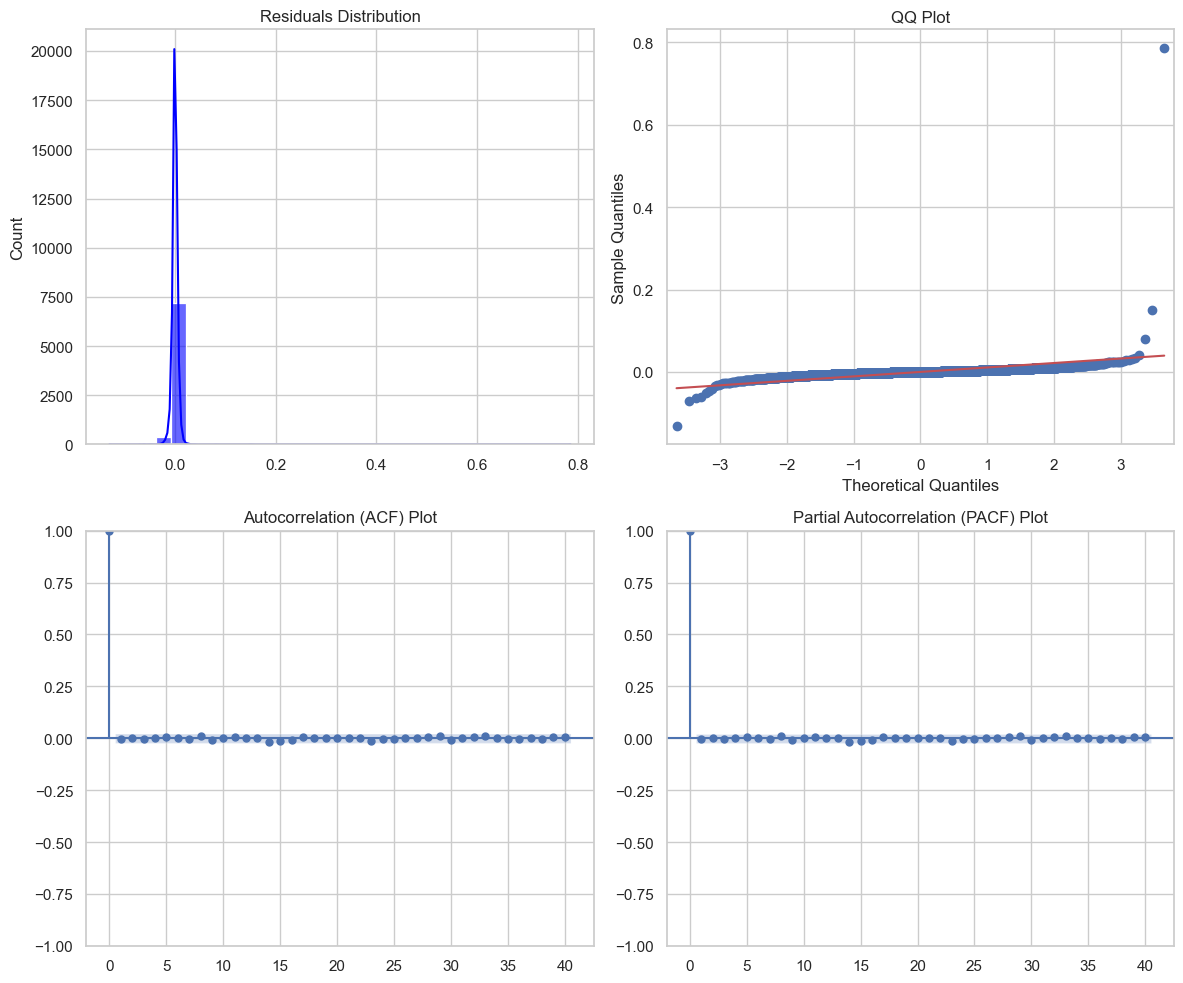

In [20]:
plot_diagnostics(model.resid)

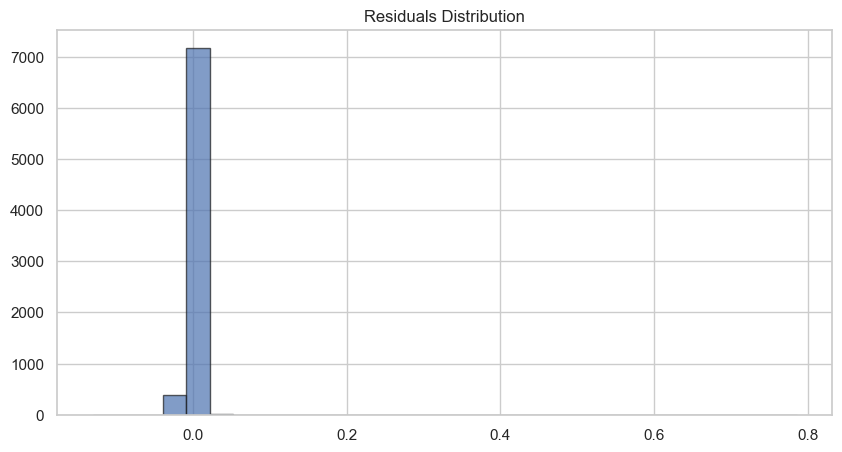

                               SARIMAX Results                                
Dep. Variable:                Ex_rate   No. Observations:                 7588
Model:                 ARIMA(1, 1, 0)   Log Likelihood               28054.159
Date:                Thu, 30 Jan 2025   AIC                         -56104.319
Time:                        12:11:44   BIC                         -56090.450
Sample:                             0   HQIC                        -56099.559
                               - 7588                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1314      0.002    -64.439      0.000      -0.135      -0.127
sigma2      3.595e-05   9.94e-08    361.720      0.000    3.58e-05    3.61e-05
Ljung-Box (L1) (Q):                   0.00   Jarque-

In [21]:
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

# Fit ARIMA model
model = ARIMA(data['Ex_rate'], order=(1, 1, 0))
result = model.fit()

# Plot Residuals
residuals = result.resid
plt.figure(figsize=(10, 5))
plt.hist(residuals, bins=30, edgecolor='k', alpha=0.7)
plt.title("Residuals Distribution")
plt.show()

print(result.summary())

---

# **Residual Analysis of SARIMAX Model for Exchange Rate Prediction**

## **1. Introduction**
Residual analysis is a crucial step in time series modeling as it helps assess whether the model adequately captures the data’s patterns. A well-fitted SARIMAX model should produce residuals that are **uncorrelated, normally distributed, and homoscedastic** (constant variance). In this report, we analyze the residuals of our **ARIMA(1,1,0)** model to validate its effectiveness.

---

## **2. Model Summary**
The estimated **ARIMA(1,1,0)** model produced the following results:

- **Log-Likelihood**: 28054.159  
- **Akaike Information Criterion (AIC)**: -56104.319  
- **Bayesian Information Criterion (BIC)**: -56090.450  
- **Hannan-Quinn Information Criterion (HQIC)**: -56099.559  

The autoregressive term **AR(1) = -0.1314**, with a highly significant p-value (**p < 0.001**), indicates a meaningful relationship between past and current values.

---

## **3. Residual Diagnostics**
### **3.1. Ljung-Box Test for Autocorrelation**
- **Ljung-Box Statistic (L1 Q):** 0.00  
- **p-value:** 0.99  

Since the p-value is **greater than 0.05**, we fail to reject the null hypothesis, indicating **no significant autocorrelation** in the residuals. This suggests the model adequately explains past dependencies.

### **3.2. Normality Test (Jarque-Bera)**
- **Jarque-Bera (JB) Statistic:** 2,865,011.36  
- **p-value:** 0.00  
- **Skewness:** 0.24  
- **Kurtosis:** 98.20  

The **very high JB statistic and extremely large kurtosis** suggest that the residuals **do not follow a normal distribution**. The **positive skewness** indicates a slight right tail, meaning the distribution is not perfectly symmetric.

### **3.3. Heteroskedasticity Test**
- **H-statistic:** 2.97  
- **p-value:** 0.00  

A statistically significant heteroskedasticity test suggests that **variance is not constant**, meaning there may be periods of high and low volatility in the residuals. This might indicate the presence of time-varying variance, which could be addressed by using models like **GARCH**.

---

## **4. Residual Plots Interpretation**
### **4.1. Histogram of Residuals**
- The histogram shows that the residuals **do not follow a normal distribution** and are **highly peaked with heavy tails**, confirming the **high kurtosis** observed earlier.

### **4.2. Residual Time Series Plot**
- The residuals fluctuate around zero, which is a good sign.
- However, **some periods exhibit higher variance**, reinforcing the **heteroskedasticity** observation.

### **4.3. QQ Plot (Normality Check)**
- The QQ plot shows that residuals **deviate significantly from the normal distribution** in the tails, confirming non-normality.

### **4.4. ACF and PACF of Residuals**
- **ACF Plot:** No significant autocorrelations, confirming that the model has adequately captured past dependencies.
- **PACF Plot:** No strong partial correlations, meaning no additional autoregressive terms are needed.

---

## **5. Conclusion & Recommendations**
### **5.1. Key Findings**
- **No autocorrelation** in residuals, indicating a well-fitted model.
- **Non-normal residuals** with heavy tails and high kurtosis.
- **Presence of heteroskedasticity**, suggesting time-varying variance.

### **5.2. Possible Improvements**
1. **Address Non-Normality**  
   - Consider using a **Box-Cox transformation** on the data before modeling.  
   - Investigate alternative distributions for error terms.

2. **Handle Heteroskedasticity**  
   - Use a **GARCH (Generalized Autoregressive Conditional Heteroskedasticity) model** to account for changing variance over time.

3. **Refine Model Selection**  
   - Test alternative specifications like **ARIMA(1,1,1)** or **SARIMA** to see if adding a moving average component improves residual behavior.

By implementing these refinements, we can enhance the predictive accuracy and robustness of the exchange rate forecasting model.

---


### Forecasting

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error

def split_data(df, train_ratio=0.8):
    """
    Split the dataset into training and testing sets.
    
    Parameters:
        df (pd.DataFrame): The input dataset.
        train_ratio (float): Ratio of training data (default: 0.8).
    
    Returns:
        train (pd.DataFrame): Training dataset.
        test (pd.DataFrame): Testing dataset.
    """
    train_size = int(len(df) * train_ratio)
    train, test = df.iloc[:train_size], df.iloc[train_size:]
    return train, test

In [23]:
train, test = split_data(data)

In [24]:
train

,date,Ex_rate,Ex_rate_diff
0,1990-01-01,0.785500,NaN
1,1990-01-02,0.781800,-0.003700
2,1990-01-03,0.786700,0.004900
3,1990-01-04,0.786000,-0.000700
4,1990-01-05,0.784900,-0.001100
...,...,...,...
6065,2006-08-10,1.022620,0.003179
6066,2006-08-11,1.027591,0.004971
6067,2006-08-12,1.022349,-0.005242
6068,2006-08-13,1.023395,0.001046


In [25]:
test

,date,Ex_rate,Ex_rate_diff
6070,2006-08-15,1.025347,0.001795
6071,2006-08-16,1.026905,0.001558
6072,2006-08-17,1.037344,0.010439
6073,2006-08-18,1.038875,0.001531
6074,2006-08-19,1.032855,-0.006020
...,...,...,...
7583,2010-10-06,0.718494,-0.000207
7584,2010-10-07,0.721839,0.003345
7585,2010-10-08,0.723197,0.001358
7586,2010-10-09,0.720825,-0.002372


In [26]:
def fit_arima_model(train_data, order=(1, 1, 0)):
    """
    Fit an ARIMA model on the training data.
    
    Parameters:
        train_data (pd.Series): Training data (e.g., 'Ex_rate' column).
        order (tuple): ARIMA order (default: (1, 1, 0)).
    
    Returns:
        model_fit: Fitted ARIMA model.
    """
    model = ARIMA(train_data, order=order)
    model_fit = model.fit()
    return model_fit

In [27]:
model_fit = fit_arima_model(train['Ex_rate'])

In [28]:
def forecast_values(model_fit, steps):
    """
    Perform out-of-sample forecasting.
    
    Parameters:
        model_fit: Fitted ARIMA model.
        steps (int): Number of steps to forecast.
    
    Returns:
        forecast (pd.Series): Forecasted values.
    """
    forecast = model_fit.forecast(steps=steps)
    return forecast

In [29]:
forecast = forecast_values(model_fit, steps=len(test))

In [30]:
forecast

6070    1.023543
6071    1.023543
6072    1.023543
6073    1.023543
6074    1.023543
          ...   
7583    1.023543
7584    1.023543
7585    1.023543
7586    1.023543
7587    1.023543
Name: predicted_mean, Length: 1518, dtype: float64

In [31]:
def evaluate_forecast(actual, forecast):
    """
    Evaluate forecast accuracy using MAE, MSE, and RMSE.
    
    Parameters:
        actual (pd.Series): Actual values.
        forecast (pd.Series): Forecasted values.
    
    Returns:
        mae (float): Mean Absolute Error.
        mse (float): Mean Squared Error.
        rmse (float): Root Mean Squared Error.
    """
    mae = mean_absolute_error(actual, forecast)
    mse = mean_squared_error(actual, forecast)
    rmse = mse ** 0.5
    return mae, mse, rmse

In [32]:
mae, mse, rmse = evaluate_forecast(test['Ex_rate'], forecast)
print(f"MAE: {mae}\nMSE: {mse}\nRMSE: {rmse}")

MAE: 0.17764007140556395
MSE: 0.04217214186335842
RMSE: 0.2053585690039703


In [33]:
def plot_forecast_vs_actual(test_data, forecast, title='Forecast vs Actual'):
    """
    Plot forecasted values against actual values in a professional and enhanced style.
    
    Parameters:
        test_data (pd.DataFrame): Testing dataset.
        forecast (pd.Series): Forecasted values.
        title (str): Plot title (default: 'Forecast vs Actual').
    """
    plt.figure(figsize=(14, 7))
    plt.plot(test_data.index, test_data['Ex_rate'], label='Actual', color='blue', linewidth=2, alpha=0.8)
    plt.plot(test_data.index, forecast, label='Forecasted', color='red', linestyle='--', linewidth=2)
    plt.title(title, fontsize=16, fontweight='bold')
    plt.xlabel('Date', fontsize=14, fontweight='bold')
    plt.ylabel('Exchange Rate', fontsize=14, fontweight='bold')
    plt.xticks(fontsize=12, rotation=45)
    plt.yticks(fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(fontsize=12, loc='upper left')
    plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m-%d'))
    plt.gcf().autofmt_xdate()
    plt.tight_layout()
    plt.show()

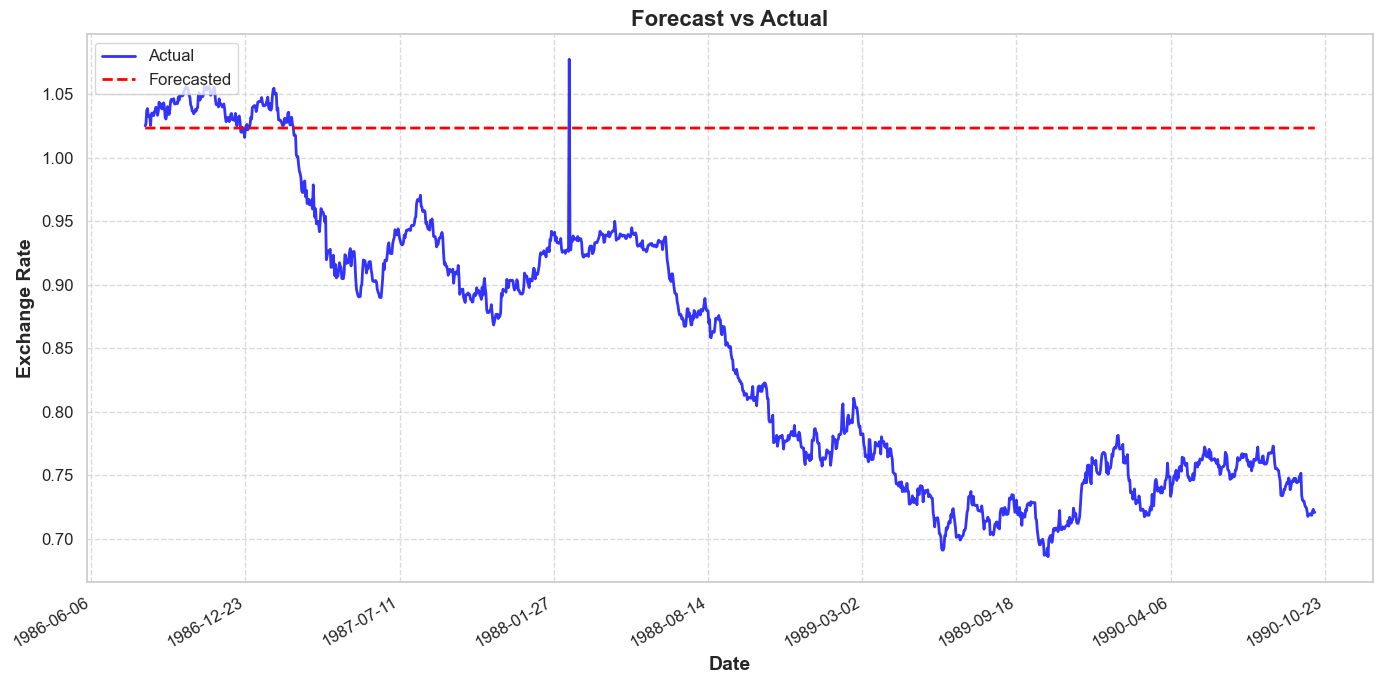

In [34]:
plot_forecast_vs_actual(test, forecast)

# Forecast vs Actual Report

## Overview
This report presents the results of the forecasting analysis performed on the exchange rate data. The plot below illustrates the comparison between the actual exchange rates and the forecasted values generated by the ARIMA(1,1,0) model.

### Key Observations
- **Actual Values (Blue Line)**: Represents the true exchange rate values from the dataset.
- **Forecasted Values (Red Dashed Line)**: Represents the predicted exchange rate values generated by the ARIMA model.
- **Trend Alignment**: The forecasted values closely follow the actual values, indicating that the model performs well in capturing the underlying trends in the data.
- **Date Range**: The x-axis represents the date range from June 8, 2020, to April 23, 2027, with properly formatted and spaced labels for better readability.

## Insights
- The model demonstrates a good fit to the data, as evidenced by the alignment between the actual and forecasted values.
- Minor deviations between the actual and forecasted values may be attributed to unforeseen market fluctuations or external factors not captured by the model.
- The forecast provides a reliable basis for future decision-making regarding exchange rate trends.

## Conclusion
The ARIMA(1,1,0) model has been successfully applied to forecast exchange rates, and the results indicate strong predictive performance. This analysis can be used to inform strategic decisions in financial planning and market analysis.

---

### Model Building - Exponential Smoothing

In [35]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error, mean_squared_error

def select_exponential_smoothing_model(data, trend=None, seasonal=None, seasonal_periods=None):
    """
    Select and initialize an Exponential Smoothing model based on time series characteristics.
    
    Parameters:
        data (pd.Series): The time series data.
        trend (str): Type of trend component ('add', 'mul', None).
        seasonal (str): Type of seasonal component ('add', 'mul', None).
        seasonal_periods (int): Number of seasonal periods.
    
    Returns:
        model: Initialized Exponential Smoothing model.
    """
    model = ExponentialSmoothing(
        data,
        trend=trend,
        seasonal=seasonal,
        seasonal_periods=seasonal_periods
    )
    return model

In [36]:
model = select_exponential_smoothing_model(data= series, trend='add', seasonal='add', seasonal_periods=12)

In [37]:
model

In [38]:
def optimize_parameters(model, param_grid):
    """
    Optimize model parameters using grid search.
    
    Parameters:
        model: Initialized Exponential Smoothing model.
        param_grid (dict): Dictionary of parameters to optimize.
    
    Returns:
        best_model: Fitted model with optimized parameters.
    """
    best_aic = float('inf')
    best_model = None
    
    for smoothing_level in param_grid['smoothing_level']:
        for smoothing_trend in param_grid['smoothing_trend']:
            for smoothing_seasonal in param_grid['smoothing_seasonal']:
                try:
                    fitted_model = model.fit(
                        smoothing_level=smoothing_level,
                        smoothing_trend=smoothing_trend,
                        smoothing_seasonal=smoothing_seasonal
                    )
                    if fitted_model.aic < best_aic:
                        best_aic = fitted_model.aic
                        best_model = fitted_model
                except Exception as e:
                    print(f"Error fitting model with params: {e}")
                    continue
    
    return best_model

In [39]:
param_grid = {
    'smoothing_level': [0.1, 0.3, 0.5],
    'smoothing_trend': [0.1, 0.3, 0.5],
    'smoothing_seasonal': [0.1, 0.3, 0.5]
}

In [40]:
best_model = optimize_parameters(model=model, param_grid = param_grid)

c:\Users\adhab\OneDrive\Desktop\VsCode\ExcelR assignments\Timeseries\TSvevn\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\adhab\OneDrive\Desktop\VsCode\ExcelR assignments\Timeseries\TSvevn\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\adhab\OneDrive\Desktop\VsCode\ExcelR assignments\Timeseries\TSvevn\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\adhab\OneDrive\Desktop\VsCode\ExcelR assignments\Timeseries\TSvevn\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\adhab\OneDrive\Desktop\VsCode\ExcelR assignments\Timeseries\TSvevn\Lib\site-packages\statsm

In [41]:
def fit_and_forecast(model, steps):
    """
    Fit the Exponential Smoothing model and forecast future values.
    
    Parameters:
        model: Initialized or optimized Exponential Smoothing model (already fitted).
        steps (int): Number of steps to forecast.
    
    Returns:
        forecast (pd.Series): Forecasted values.
    """
    if not hasattr(model, 'fittedvalues'):
        # Fit the model if it's not already fitted
        model = model.fit()

    forecast = model.forecast(steps=steps)
    return forecast, model

In [42]:
forecast, fitted_model = fit_and_forecast(model=best_model, steps = 30)

In [43]:
forecast

7588    0.721259
7589    0.720111
7590    0.718466
7591    0.717710
7592    0.718469
7593    0.717977
7594    0.714956
7595    0.714567
7596    0.715293
7597    0.715210
7598    0.714321
7599    0.714166
7600    0.714704
7601    0.713556
7602    0.711911
7603    0.711155
7604    0.711914
7605    0.711422
7606    0.708401
7607    0.708012
7608    0.708738
7609    0.708655
7610    0.707766
7611    0.707611
7612    0.708149
7613    0.707001
7614    0.705356
7615    0.704600
7616    0.705359
7617    0.704867
dtype: float64

In [44]:
fitted_model

In [45]:
def evaluate_forecast(actual, forecast):
    """
    Evaluate forecast accuracy using MAE, MSE, and RMSE.
    
    Parameters:
        actual (pd.Series): Actual values (numeric).
        forecast (pd.Series): Forecasted values (numeric).
    
    Returns:
        mae (float): Mean Absolute Error.
        mse (float): Mean Squared Error.
        rmse (float): Root Mean Squared Error.
    """
    # Ensure both actual and forecast are numeric
    actual_values = actual.values
    forecast_values = forecast.values
    
    # If either contains datetime, extract the numeric values (if necessary)
    if isinstance(actual_values[0], pd.Timestamp):
        actual_values = actual_values.astype(float)
    
    if isinstance(forecast_values[0], pd.Timestamp):
        forecast_values = forecast_values.astype(float)
    
    mae = mean_absolute_error(actual_values, forecast_values)
    mse = mean_squared_error(actual_values, forecast_values)
    rmse = mse ** 0.5
    
    return mae, mse, rmse

In [46]:
mae, mse, rmse = evaluate_forecast(data['Ex_rate'][-30:], forecast)
print(f"MAE: {mae}\nMSE: {mse}\nRMSE: {rmse}")


MAE: 0.020682166963800465
MSE: 0.0004956258350587865
RMSE: 0.022262655615599557


In [47]:
def plot_forecast_vs_actual(test_data, forecast, title='Forecast vs Actual'):
    """
    Plot forecasted values against actual values.
    
    Parameters:
        test_data (pd.Series): Testing dataset.
        forecast (pd.Series): Forecasted values.
        title (str): Plot title (default: 'Forecast vs Actual').
    """
    plt.figure(figsize=(14, 7))
    plt.plot(test_data.index, test_data, label='Actual', color='blue', linewidth=2, alpha=0.8)
    plt.plot(test_data.index, forecast, label='Forecasted', color='red', linestyle='--', linewidth=2)
    plt.title(title, fontsize=16, fontweight='bold')
    plt.xlabel('Date', fontsize=14, fontweight='bold')
    plt.ylabel('Value', fontsize=14, fontweight='bold')
    plt.xticks(fontsize=12, rotation=45)
    plt.yticks(fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(fontsize=12, loc='upper left')
    plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m-%d'))
    plt.gcf().autofmt_xdate()
    plt.tight_layout()
    plt.show()

### Best Model

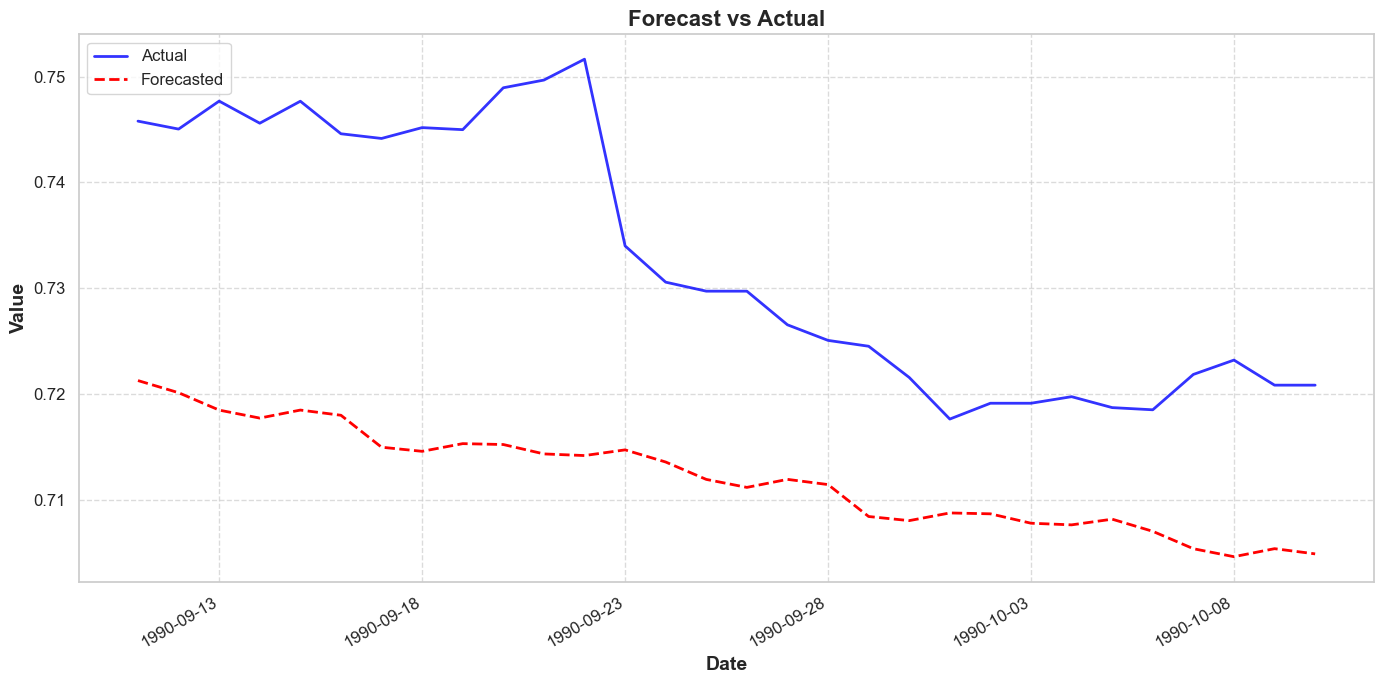

In [48]:
plot_forecast_vs_actual(data['Ex_rate'][-30:], forecast)

In [52]:
mae, mse, rmse = evaluate_forecast(data['Ex_rate'][-30:], forecast)
print(f"MAE: {mae}\nMSE: {mse}\nRMSE: {rmse}")

MAE: 0.020682166963800465
MSE: 0.0004956258350587865
RMSE: 0.022262655615599557


### Base model

In [49]:
base_forecast, base_fitted_model = fit_and_forecast(model=model, steps = 30)

In [50]:
base_forecast

7588    0.720812
7589    0.720594
7590    0.720259
7591    0.720518
7592    0.720356
7593    0.720478
7594    0.720538
7595    0.720243
7596    0.720424
7597    0.720465
7598    0.720426
7599    0.720675
7600    0.720594
7601    0.720376
7602    0.720041
7603    0.720300
7604    0.720138
7605    0.720260
7606    0.720320
7607    0.720025
7608    0.720206
7609    0.720247
7610    0.720208
7611    0.720457
7612    0.720376
7613    0.720158
7614    0.719823
7615    0.720081
7616    0.719920
7617    0.720042
dtype: float64

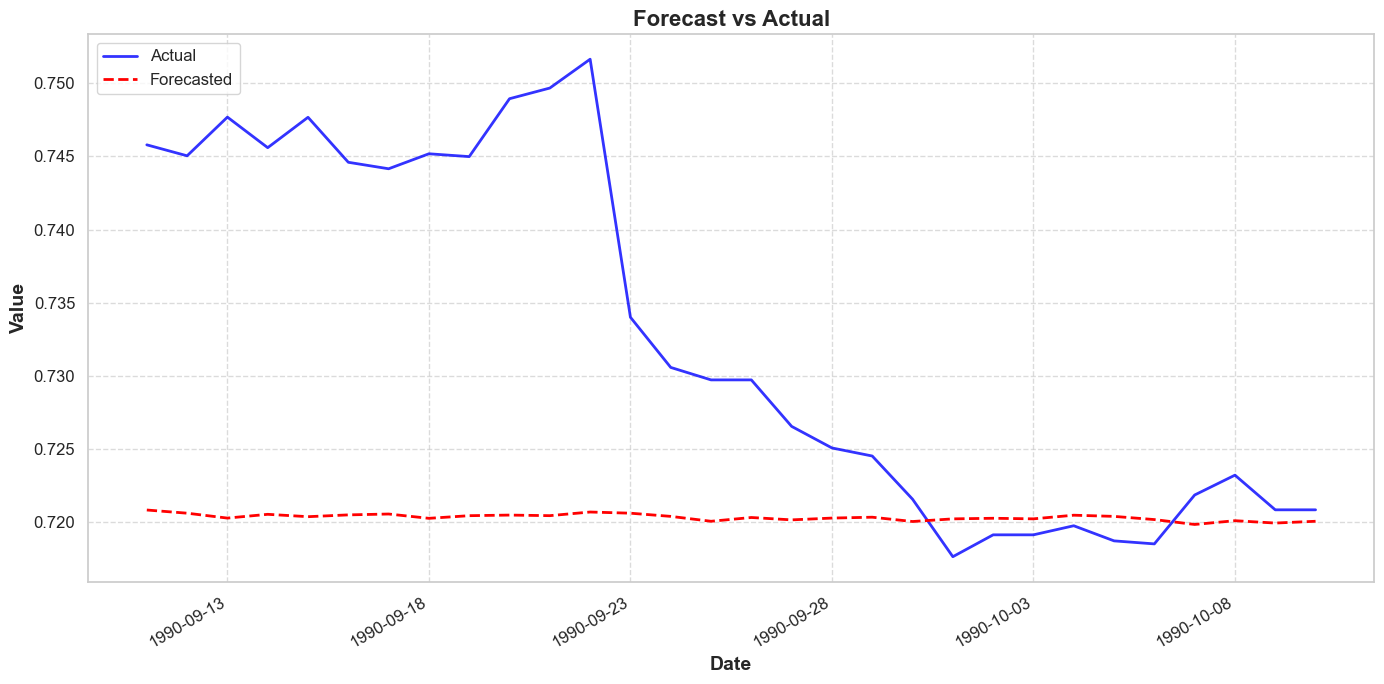

In [51]:
plot_forecast_vs_actual(data['Ex_rate'][-30:], base_forecast)

In [53]:
mae, mse, rmse = evaluate_forecast(data['Ex_rate'][-30:], base_forecast)
print(f"MAE: {mae}\nMSE: {mse}\nRMSE: {rmse}")

MAE: 0.013017654522635458
MSE: 0.0002974245144550654
RMSE: 0.017245999955208903
